## 1. Load basic modules 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# 2.Load CSV 

In [2]:
data = pd.read_csv("../documents/data_both_scores.csv")
data.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,AgeinYr,AgeCat,bmi,bmi_cat,fram,esc
0,f,168,62.0,110.0,80.0,normal,normal,no,no,yes,0,50,"[50, 60)",21.97,Normal Weight,18,2
1,m,156,85.0,140.0,90.0,high,normal,no,no,yes,1,55,"[50, 60)",34.93,Obesity,16,10
2,m,165,64.0,130.0,70.0,high,normal,no,no,no,1,51,"[50, 60)",23.51,Normal Weight,13,6
3,f,169,82.0,150.0,100.0,normal,normal,no,no,yes,1,48,"[40, 50)",28.71,Overweight,16,2
4,m,156,56.0,100.0,60.0,normal,normal,no,no,no,0,47,"[40, 50)",23.01,Normal Weight,15,3


In [3]:
data.shape

(67359, 17)

# 3. Analysis and visualizations of the desired target

## Predict variable (desired target): Cardio

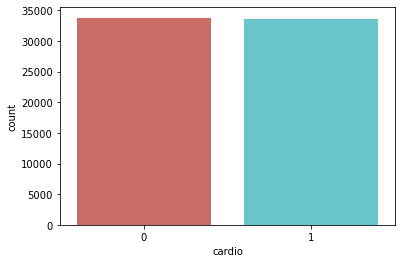

In [4]:
sns.countplot(x = 'cardio', data = data, palette = 'hls')
plt.show()

**As we can see, we have balanced  amounts of cardiovascular events**

<AxesSubplot:>

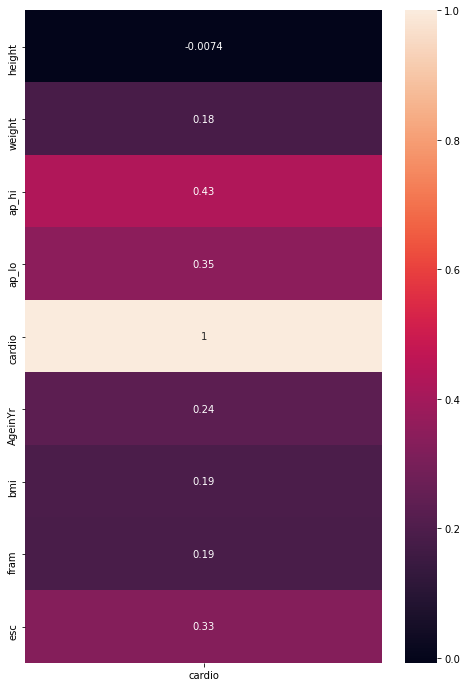

In [5]:
plt.figure(figsize=(8,12))
sns.heatmap(data.corr()[['cardio']], annot=True)

In [6]:
model = sm.GLM.from_formula("cardio ~ gender + AgeinYr + cholesterol + gluc + smoke + alco + active + bmi + fram + esc", family = sm.families.Binomial(), data=data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 cardio   No. Observations:                67359
Model:                            GLM   Df Residuals:                    67346
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39888.
Date:                Tue, 28 Jun 2022   Deviance:                       79777.
Time:                        11:08:55   Pearson chi2:                 7.27e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.5853      0.122     -4.807      0.000      -0.824      -0.347
gender[T.m]              -0.9354      0.028    -32.907      0.000      -0.991      -0.880
cholesterol[T.high]       0.1817      0.043      4.251      0.000       0.098       0.266
cholesterol[T.normal]    -0.3790      0.030    -12.764      0.000      -0.437      -0.321
gluc[T.normal]            0.3987      0.039     10.111      0.000       0.321       0.476
gluc[T.prediabetes]       0.4294      0.051      8.476      0.000       0.330       0.529
smoke[T.yes]             -1.9238      0.043    -44.742      0.000      -2.008      -1.839
alco[T.yes]              -0.1647      0.041     -4.059      0.000      -0.244      -0.085
active[T.yes]            -0.1720      0.021     -8.028      0.000      -0.214      -0.130
AgeinYr                  -0.0664      0.002    -29.446      0.000      -0.071      -0.062
bmi                       0.0445      0.002     24.430      0.000       0.041       0.048
fram                      0.1038      0.004     28.409      0.000       0.097       0.111
esc                       0.4455      0.008     57.218      0.000       0.430       0.461
=========================================================================================
"""

**The p-values for most of the variables are smaller than 0.05, so we keep all the features**

In [31]:
data[["cardio", "gender", "AgeinYr", "cholesterol", "gluc", "smoke", "alco", "active", "bmi", "fram", "esc"]].corr()

,cardio,AgeinYr,bmi,fram,esc
cardio,1.000000,0.235421,0.190022,0.186343,0.330570
AgeinYr,0.235421,1.000000,0.096048,0.398675,0.681185
bmi,0.190022,0.096048,1.000000,0.066898,0.232791
fram,0.186343,0.398675,0.066898,1.000000,0.246095
esc,0.330570,0.681185,0.232791,0.246095,1.000000


# 4.Transform the Categorical Variables: Creating Dummy Variables

In [8]:
categoricals = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]

enc = OneHotEncoder(drop = "first")
X = data[categoricals]
enc.fit(X)
enc.categories_

[array(['f', 'm'], dtype=object),
 array(['bordering', 'high', 'normal'], dtype=object),
 array(['diabetes', 'normal', 'prediabetes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object)]

In [9]:
dummies = enc.transform(X).toarray()
dummies
dummies_df = pd.DataFrame(dummies)
dummies_df

col_names = [categoricals[i] + '_' + enc.categories_[i] for i in range(len(categoricals))] 
                                                                 #range(len(categoricals)) = 0 a 6
col_names_drop_first = [sublist[i] for sublist in col_names for i in range(len(sublist)) if i != 0]
dummies_df.columns = col_names_drop_first
variables_numericas = ["height", "weight", "AgeinYr", "ap_hi", "ap_lo", "bmi", "fram", "esc"]
data_numerica = data[variables_numericas]
data_final = pd.concat([dummies_df, data_numerica,data["cardio"]], axis = 1)
data_final.head()

,gender_m,cholesterol_high,cholesterol_normal,gluc_normal,gluc_prediabetes,smoke_yes,alco_yes,active_yes,height,weight,AgeinYr,ap_hi,ap_lo,bmi,fram,esc,cardio
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,168,62.0,50,110.0,80.0,21.97,18,2,0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,156,85.0,55,140.0,90.0,34.93,16,10,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,165,64.0,51,130.0,70.0,23.51,13,6,1
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,169,82.0,48,150.0,100.0,28.71,16,2,1
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,156,56.0,47,100.0,60.0,23.01,15,3,0


## 5.Logistic Regression Model Fitting


In [10]:
X = data_final.drop("cardio", axis = 1)
y = data_final["cardio"]

In [11]:
# We separate the training data from the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0)

In [12]:
# We standardize the data to obtain a correct regularization
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [13]:
lr = LogisticRegression()
lr.fit(X_train_std, y_train)

LogisticRegression()

### Predicting the test set results and calculating the accuracy



In [14]:
accuracy_score(y_train, lr.predict(X_train_std))

0.729092024782755

Text(33.0, 0.5, 'Reales')

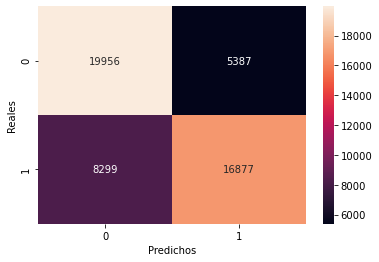

In [15]:
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_std)), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [16]:
lr.predict_proba(X_train_std[y_train==0])[:,1]

array([0.38325133, 0.19141405, 0.46173223, ..., 0.27865534, 0.45793084,
       0.39601461])

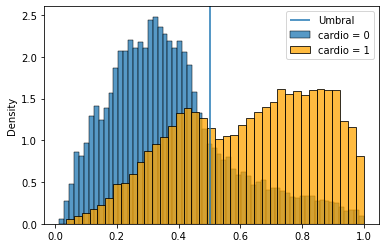

In [17]:
# Histograma de probabilidades
sns.histplot(data = lr.predict_proba(X_train_std[y_train==0])[:,1], stat = 'density')
sns.histplot(data = lr.predict_proba(X_train_std[y_train==1])[:,1], stat = 'density', color = 'orange')
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'cardio = 0', 'cardio = 1'])

In [18]:
#Dada la naturaleza del probelma, conviene utilizar una estrategia que impida clasificar como pacientes sanos a aquellos que están en riesgo.

In [28]:
umbral = 0.2
probs = lr.predict_proba(X_train_std)[:,1]
y_pred_train = probs > umbral

In [29]:
accuracy_score(y_train, y_pred_train)

0.5758823412973336

Text(33.0, 0.5, 'Reales')

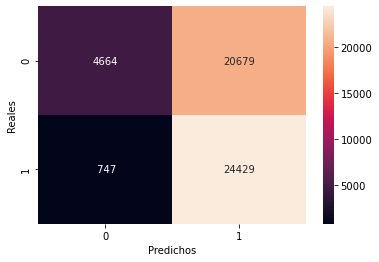

In [30]:
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')